In [37]:
import numpy as np
from obp.dataset import OpenBanditDataset
from pathlib import Path
import time
from sklearn.linear_model import RidgeCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
import pandas as pd

from tools.estimate import get_value_estimators, get_estimator_stats
from tools.policy import UniformPolicy 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_palette("colorblind")
colors = sns.color_palette()
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["axes.titlesize"] = 14

X_MED = 10
Y_MED = 6
XY_MED = (X_MED, Y_MED)

### Load in data

The open bandit dataset can be download [here](https://research.zozo.com/data.html) and all data should be saved in a directory named `obd`

In [135]:
# the logging policies to be evaluated, can be 'random','bts',or both
policies = ['random', 'bts']

# the campaigns to run, can be any subset of {'all','men','women'}
campaigns = ['men']
ob_datasets = {}
for policy in policies:
    for campaign in campaigns:
        ob_datasets[f'{policy}_{campaign}'] = OpenBanditDataset(behavior_policy=policy,
                                                                campaign=campaign,
                                                                data_path=Path("obd"))

/home/aidanclaffey/anaconda3/envs/bandits-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Run experiments

In [255]:
trials = 50
dataset_sizes = [0.01,0.05,0.1]
val_ests = {}
for campaign in campaigns:
    for logging_policy in policies:
        for size in dataset_sizes:
            val_ests[f"{campaign}-{logging_policy}-{size*100}%"] = []
            print(f"{campaign}-{logging_policy} -> {campaign} - random, using {size*100}% of data")
            for i in tqdm(range(trials)):
                feedback = ob_datasets[f'{logging_policy}_{campaign}'].sample_bootstrap_bandit_feedback(random_state=i)
                n_actions = feedback['n_actions']
                full_size = feedback['n_rounds']
                trial_size = int(full_size*size)
                idx = np.arange(trial_size)
                target_policy = UniformPolicy(num_actions=n_actions)
                propensities = feedback['pscore'][idx]
                contexts = feedback['context'][idx]
                actions = feedback['action'][idx]
                rewards = feedback['reward'][idx]
                est = get_value_estimators(
                    target_policy, contexts, actions, rewards, propensities, skip_nonlin = True
                )
                val_ests[f"{campaign}-{logging_policy}-{size*100}%"].append(est)

### Save results

In [260]:
frames = {}
for key in val_ests.keys():
    campaign = key[:key.find('-')]
    df = pd.DataFrame(val_ests[key])
    true_policy_value = ob_datasets[f'random_{campaign}'].calc_on_policy_policy_value_estimate('random',campaign)
    frames[key] = get_estimator_stats(df, true_parameter_value=true_policy_value)
    frames[key].to_csv(f'results/{key[:-1].replace("-","_").replace(".","_")}.csv')

/home/aidanclaffey/anaconda3/envs/bandits-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Bar charts of results

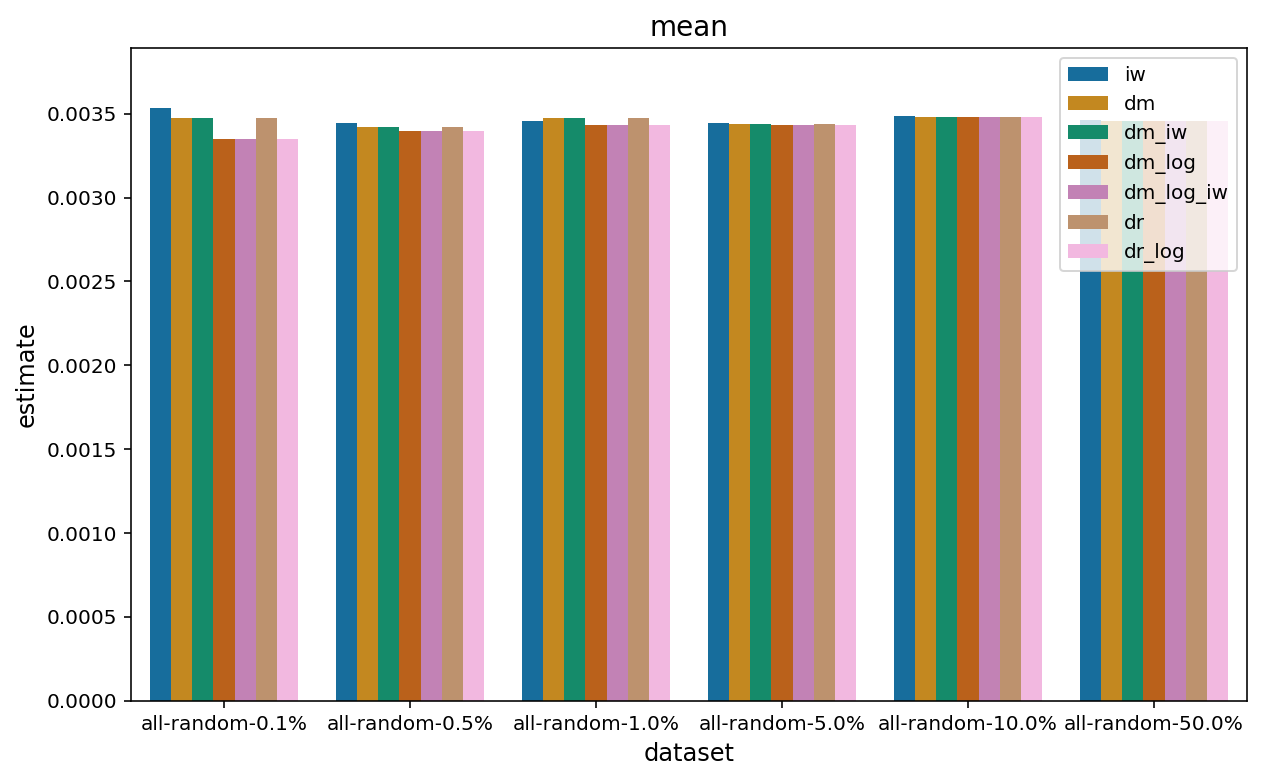

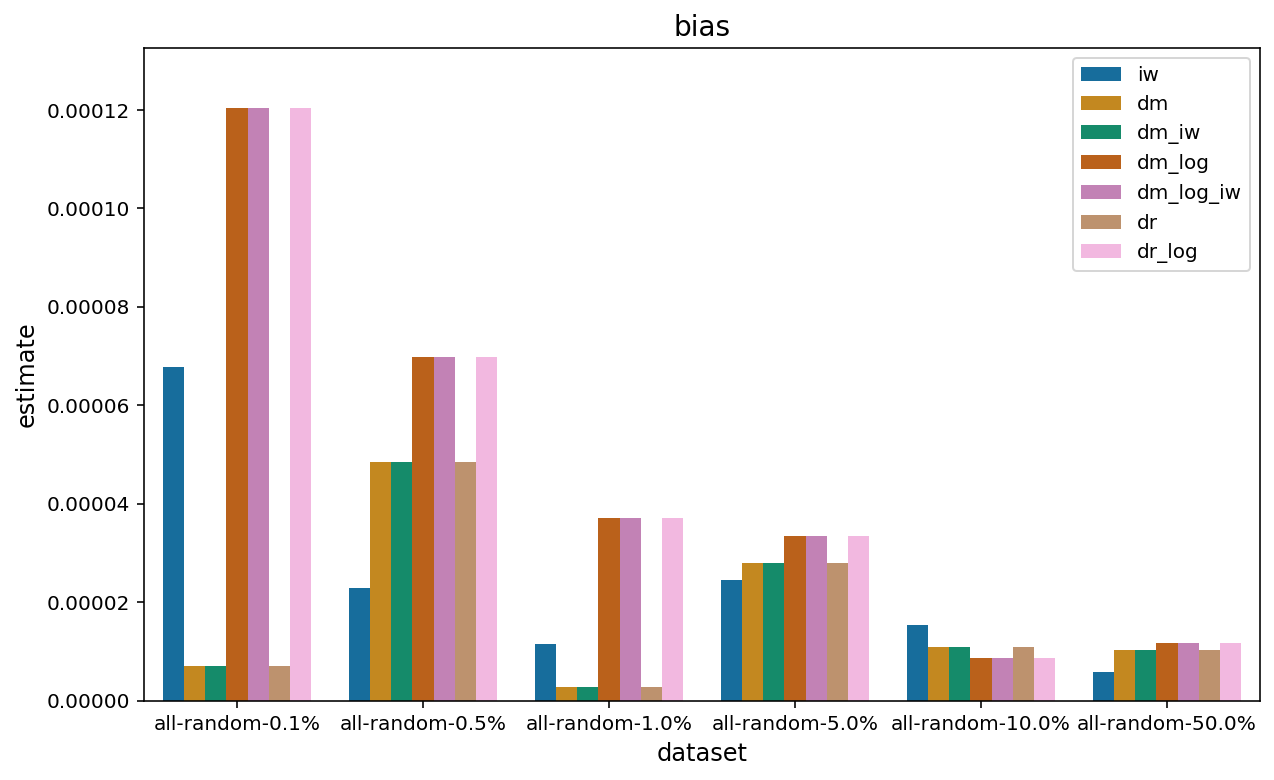

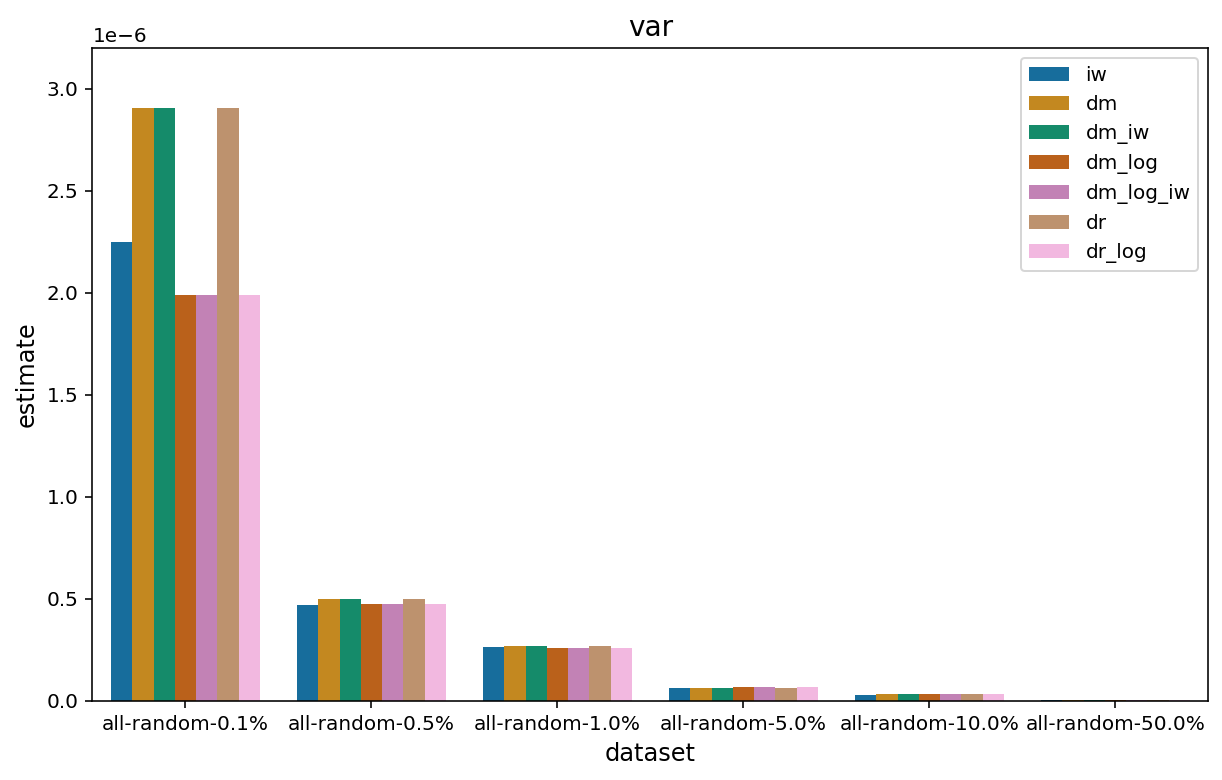

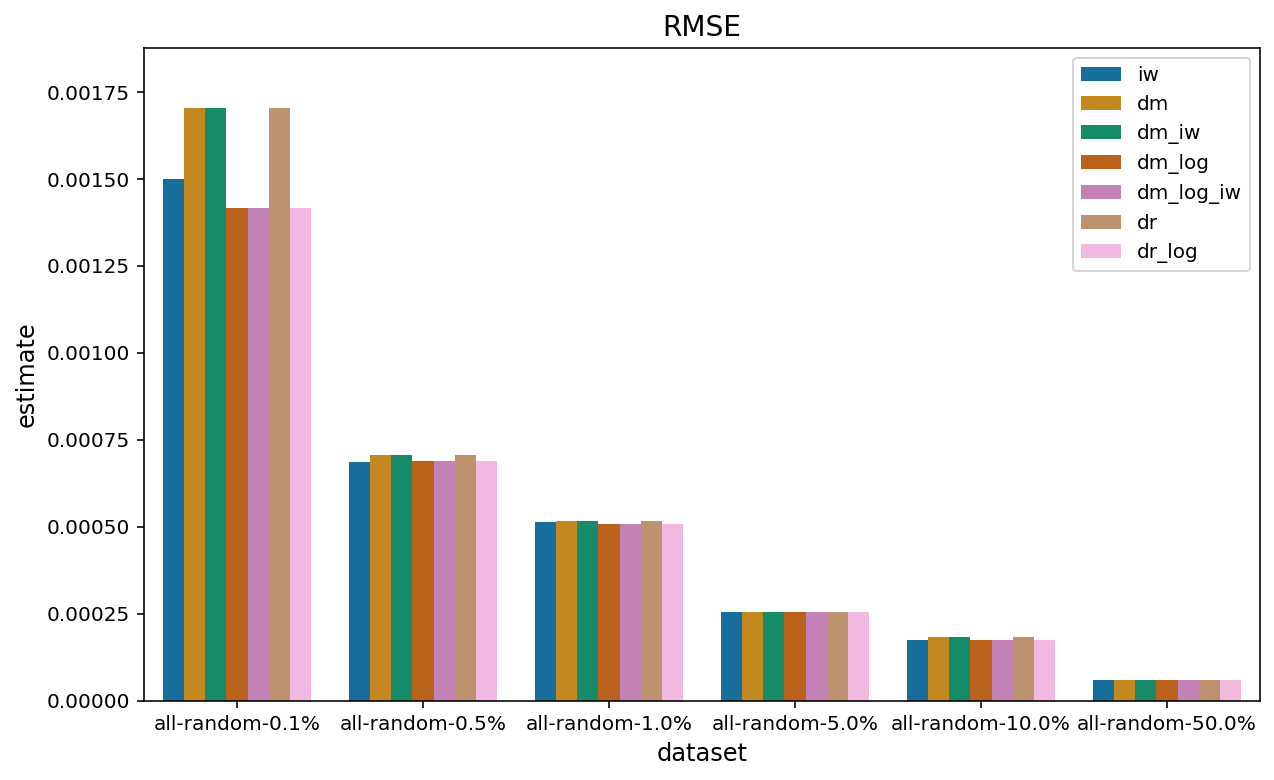

In [159]:
stats = ["mean", "bias", "var", "RMSE"]
skip_nonlin = True
for stat in stats:
    iw = []
    dm = []
    dm_iw = []
    dm_log = []
    dm_log_iw = []
    dr = []
    dr_log = []
    dm_rf = []
    dr_rf = []
    for data in val_ests.keys():

        iw.append(abs(frames[data][stat][0]))
        dm.append(abs(frames[data][stat][1]))
        dm_iw.append(abs(frames[data][stat][2]))
        dm_log.append(abs(frames[data][stat][3]))
        dm_log_iw.append(abs(frames[data][stat][4]))
        dr.append(abs(frames[data][stat][5]))
        dr_log.append(abs(frames[data][stat][6]))

        if not skip_nonlin:
            dm_rf.append(abs(frames[data][stat][7]))
            dr_rf.append(abs(frames[data][stat][8]))

    if skip_nonlin:
        df = pd.DataFrame(
            np.c_[iw, dm, dm_iw, dm_log, dm_log_iw, dr, dr_log],
            index=val_ests.keys(),
            columns=["iw", "dm", "dm_iw", "dm_log", "dm_log_iw", "dr", "dr_log"],
        )
        df = (
            df.reset_index()
            .rename({"index": "dataset"}, axis=1)
            .melt(id_vars=["dataset"], var_name="estimator", value_name="estimate")
        )
    else:
        df = pd.DataFrame(
            np.c_[iw, dm, dm_iw, dm_log, dm_log_iw, dm_rf, dr, dr_log, dr_rf],
            index=val_ests.keys(),
            columns=[
                "iw",
                "dm",
                "dm_iw",
                "dm_log",
                "dm_log_iw",
                "dm_rf",
                "dr",
                "dr_log",
                "dr_rf",
            ],
        )
        df = (
            df.reset_index()
            .rename({"index": "dataset"}, axis=1)
            .melt(id_vars=["dataset"], var_name="estimator", value_name="estimate")
        )

    fig, ax = plt.subplots(figsize=XY_MED)
    y_max = df[df['estimator']!= "dm_rf"]['estimate'].max()
    ax.set_ylim(0,y_max*1.1)
    sns.barplot(data=df, x="dataset", y="estimate", hue="estimator", ax=ax)
    ax.legend()
    ax.set_title(stat)
    ax.tick_params(axis="x", labelrotation=0)
    plt.savefig(f'figures/{stat}_{campaign}.png', bbox_inches='tight')


### Line plot of results for *men* and *women* campaigns

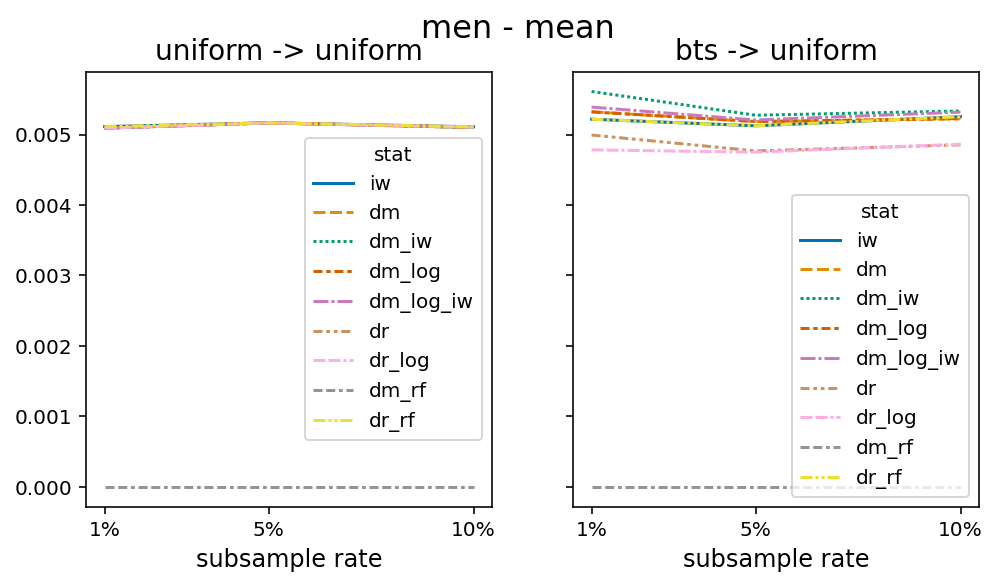

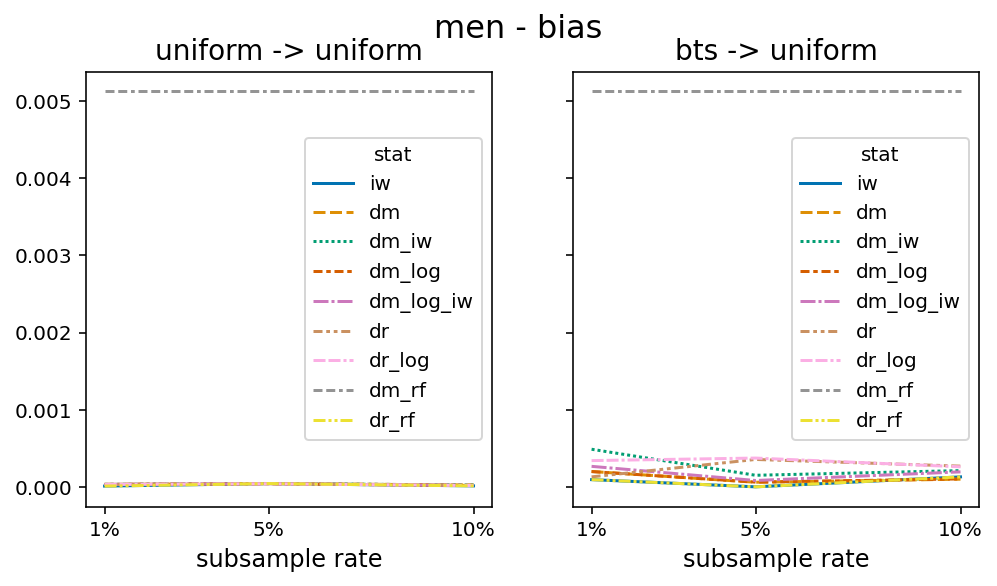

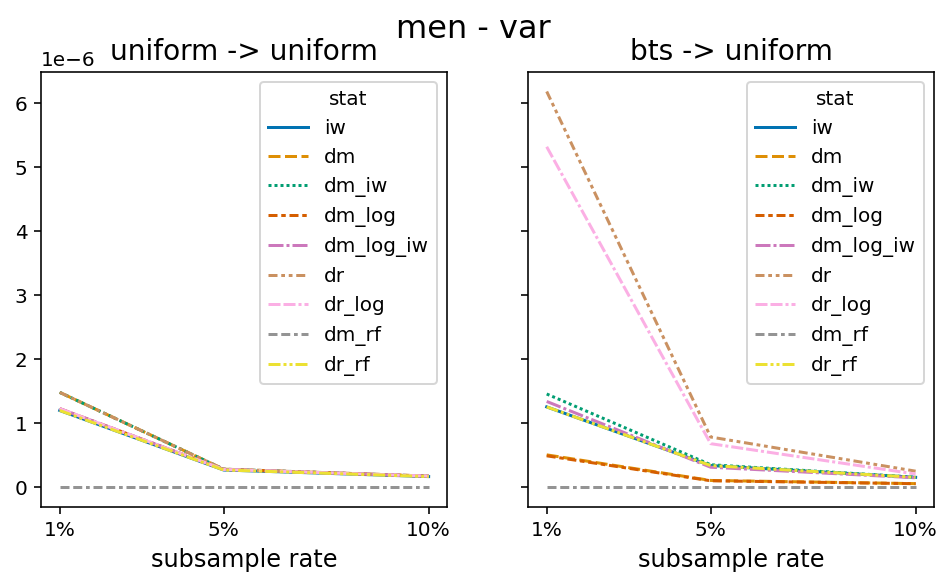

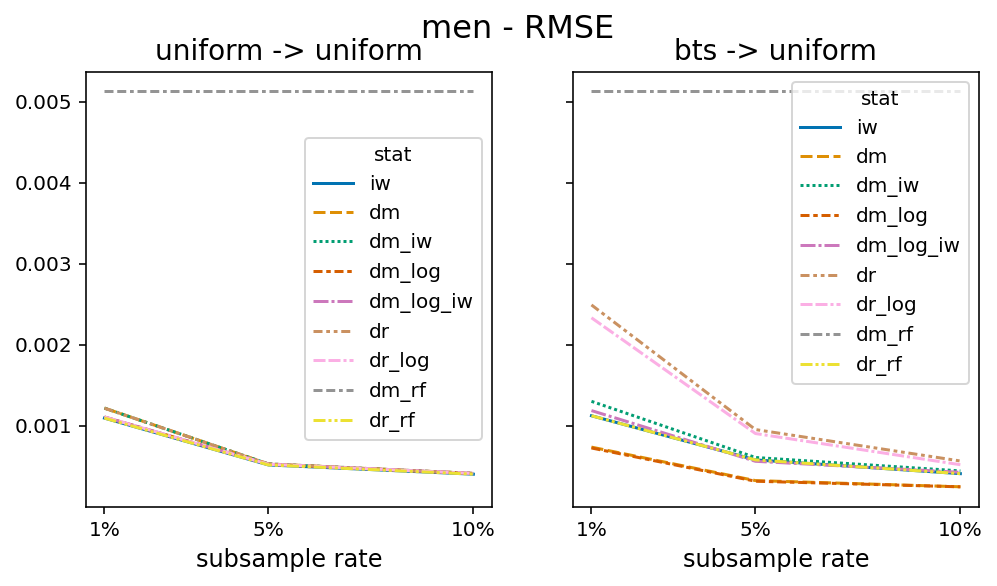

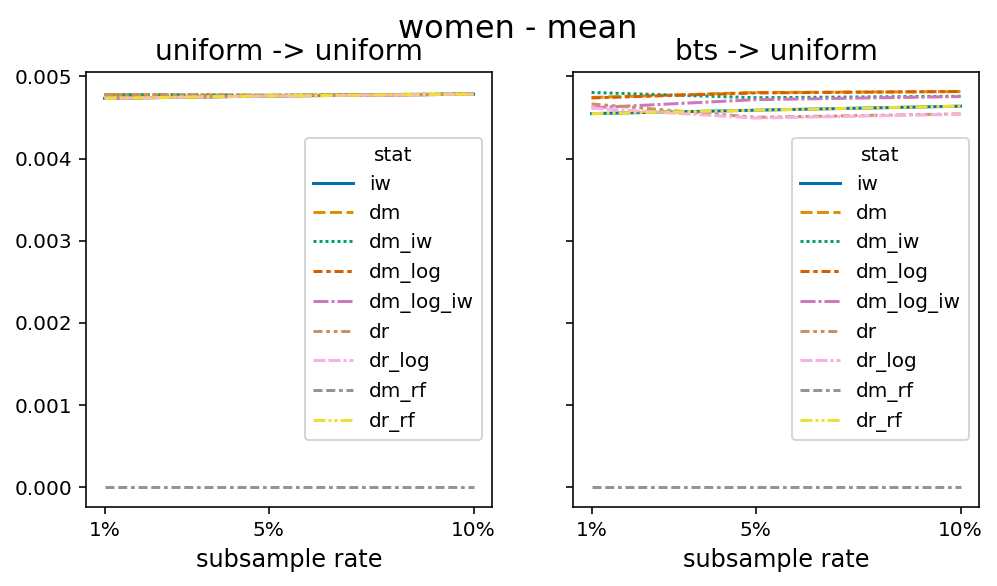

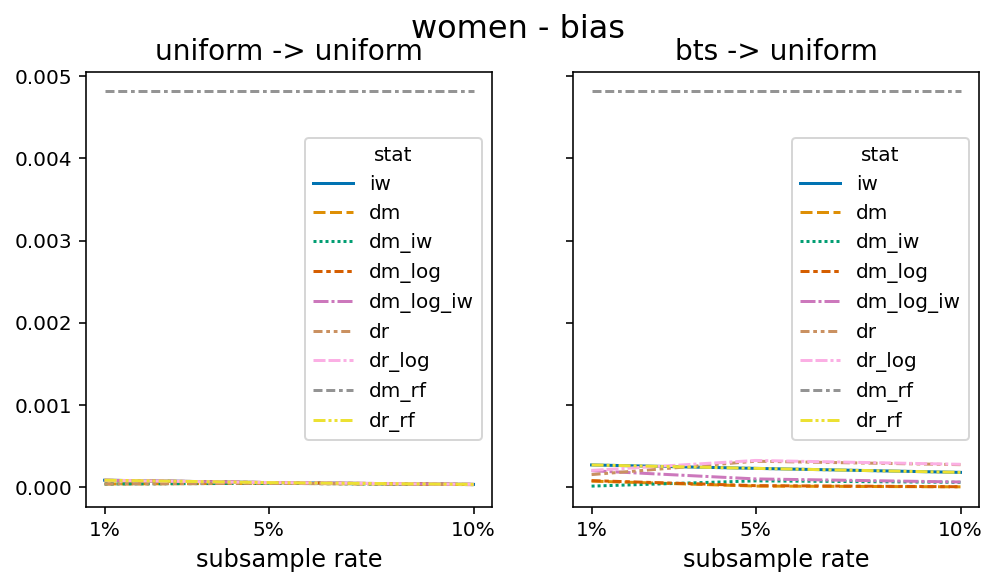

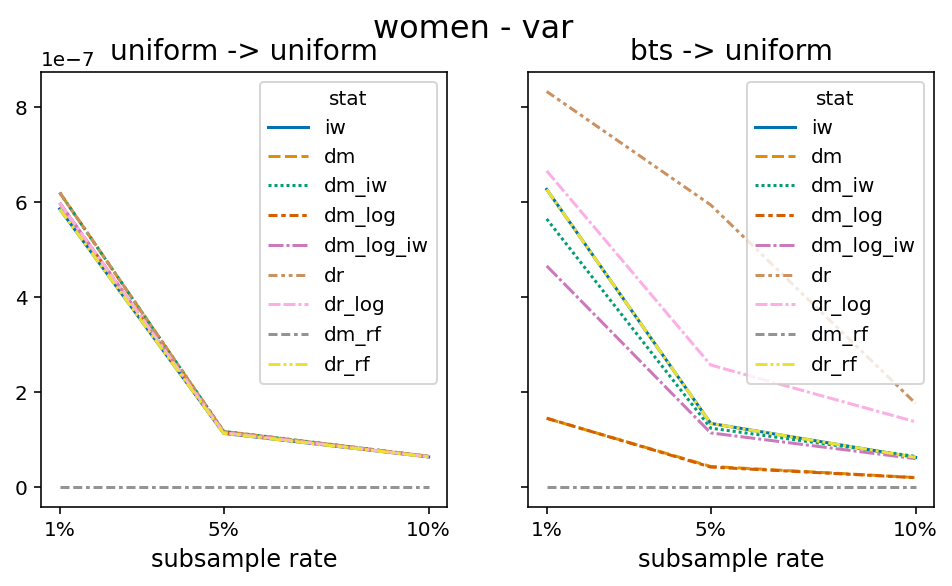

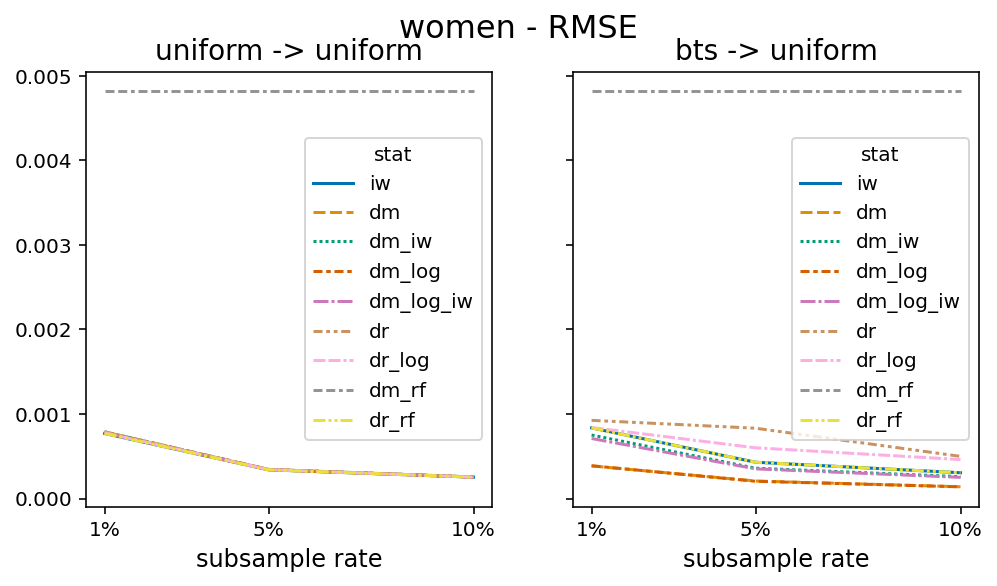

In [261]:
sizes = [0.01,0.05,0.1]

campaigns = ['men','women']
policies = ['bts','random']
results = {}
for campaign in ['men','women']:
    frames = {}
    for policy in ['random','bts']:
        for size in sizes:
            frames[f'{policy}_{str(size*100).replace(".","_")}_{campaign}'] = pd.read_csv(f'results/obd/{campaign}_{policy}_{int(100*size)}.csv', index_col='stat')
    results[campaign] = frames
    
for campaign in campaigns:
    for stat in stats:
        sizes = all_sizes if campaign=='all' else small_sizes
        dfs = {}
        for policy in policies:
            dfs[policy] = pd.DataFrame()
            for size in [round(size*100,1) for size in sizes]:
                size_str = str(size).replace('.','_')
                dfs[policy].loc[:,size] = results[campaign][f'{policy}_{size_str}_{campaign}'][stat]
        else:
            fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=True)
            ax[0].set_xticks([size*100 for size in sizes])
            ax[0].set_xticklabels([f'{int(size*100)}%' for size in sizes])
            ax[0].set_title(f'uniform -> uniform')
            ax[0].set_xlabel('subsample rate')
            sns.lineplot(data=dfs['random'].T, ax = ax[0])
            
            ax[1].set_xticks([size*100 for size in sizes])
            ax[1].set_xticklabels([f'{int(size*100)}%' for size in sizes])
            ax[1].set_title(f'bts -> uniform')
            ax[1].set_xlabel('subsample rate')
            sns.lineplot(data=dfs['bts'].T, ax = ax[1])
            fig.suptitle(f'{campaign} - {stat}', fontsize=16)
        plt.show()
                

### Line plot for *all* campaign results
(Only looked at *uniform -> uniform*)

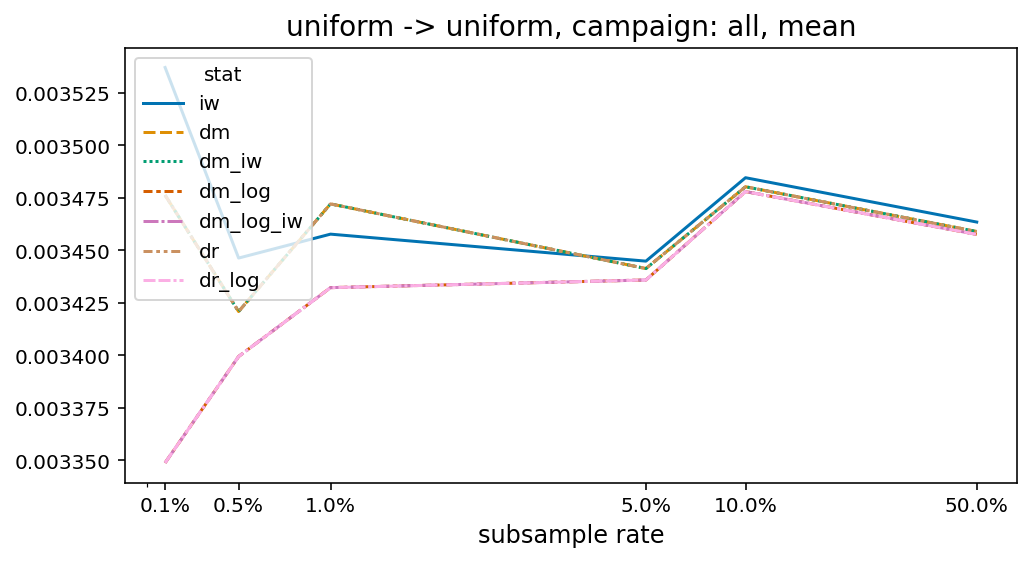

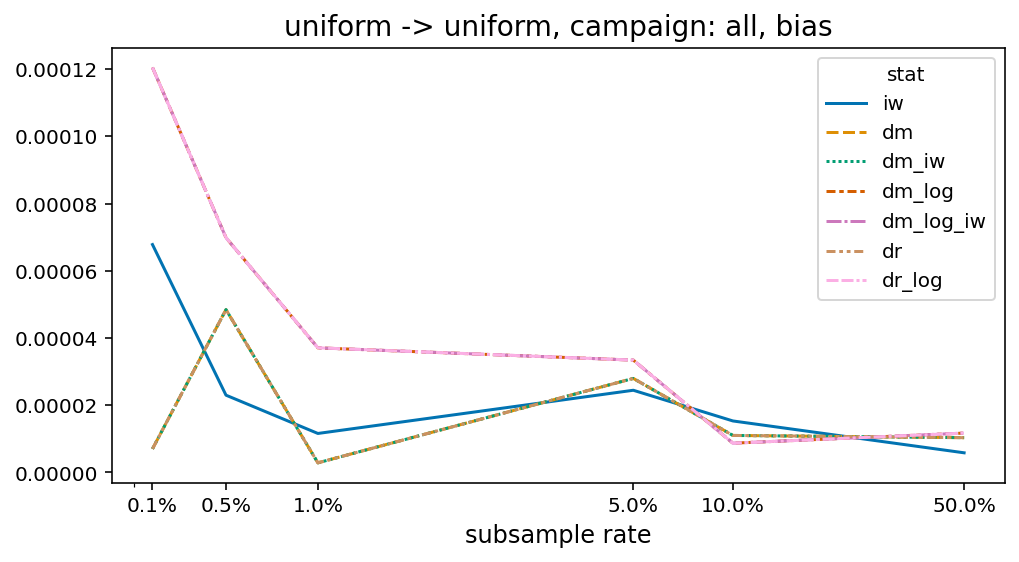

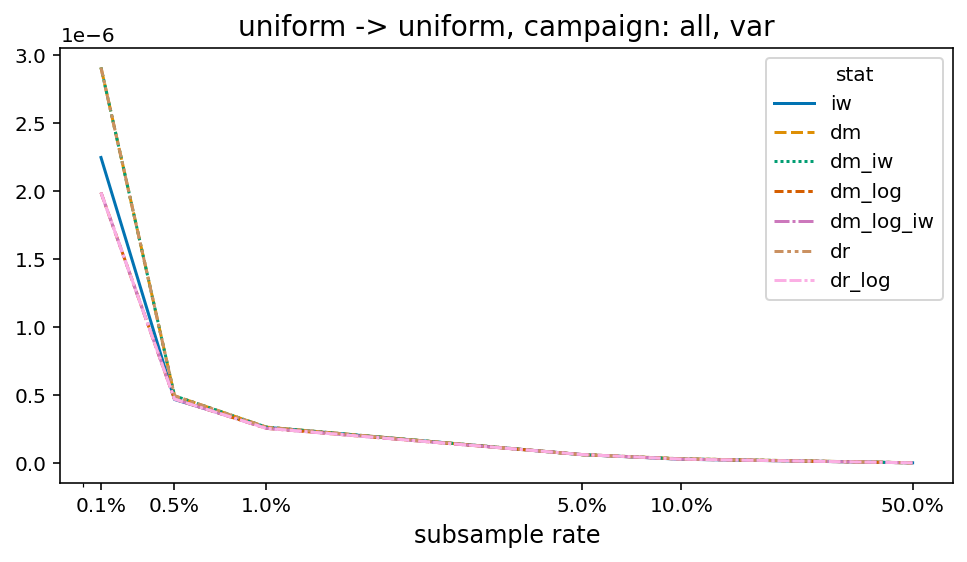

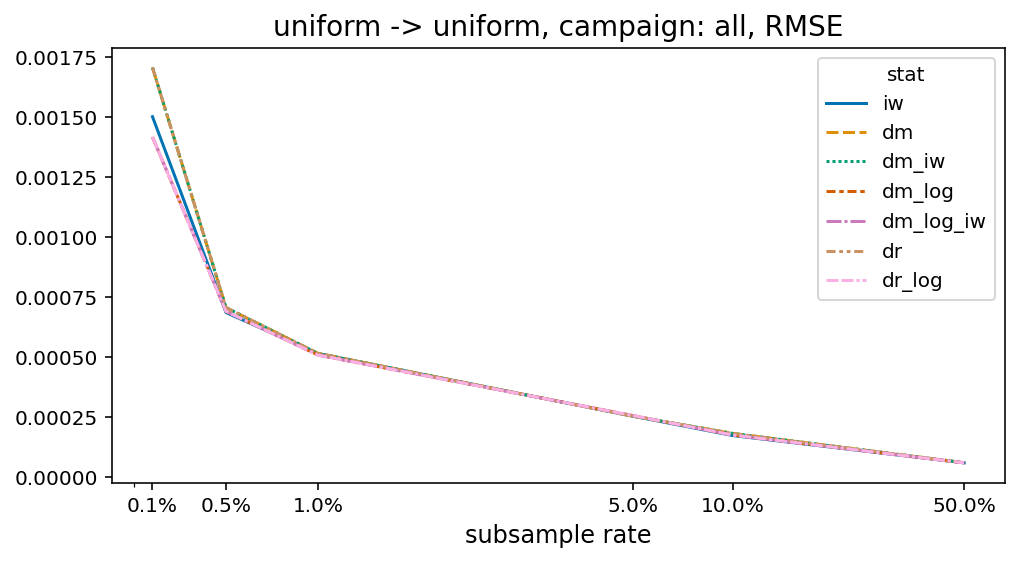

In [262]:
sizes = [0.001,0.005,0.01,0.05,0.1,0.5]
for size in [str(round(size*100,1)).replace('.','_') for size in sizes]:
    frames[f'random_{size}_all'] = pd.read_csv(f'results/obd/all_random_{size}.csv', index_col='stat')
        
results['all'] = frames
for stat in stats:
    df = pd.DataFrame()
    for size in [round(size*100,1) for size in sizes]:
        size_str = str(size).replace('.','_')
        df.loc[:,size] = results['all'][f'random_{size_str}_all'][stat]   
    fig, ax = plt.subplots(1,1, figsize=(8,4), sharey=True)
    ax.set_xscale('symlog')
    ax.set_xticks([size*100 for size in sizes])
    ax.set_xticklabels([f'{size*100}%' for size in sizes])
    ax.set_title(f'uniform -> uniform, campaign: all, {stat}')
    ax.set_xlabel('subsample rate')
    sns.lineplot(data=df.T, ax=ax)